# Explore here

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split
datos = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv')

datos.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
datos.to_csv('/workspaces/machine-learning-zalo/data/raw/datos.csv', index=False)

In [5]:
datos.shape

(48895, 16)

In [6]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [7]:
#Ver duplicados de columnas

# Iterar a través de cada columna en el DataFrame
for columna in datos.columns:
    # Calcular el número de valores duplicados para esa columna
    num_duplicados = datos[columna].duplicated().sum()
    # Imprimir el resultado
    print(f'El número de valores duplicados en la columna {columna} es: {num_duplicados}')



El número de valores duplicados en la columna id es: 0
El número de valores duplicados en la columna name es: 989
El número de valores duplicados en la columna host_id es: 11438
El número de valores duplicados en la columna host_name es: 37442
El número de valores duplicados en la columna neighbourhood_group es: 48890
El número de valores duplicados en la columna neighbourhood es: 48674
El número de valores duplicados en la columna latitude es: 29847
El número de valores duplicados en la columna longitude es: 34177
El número de valores duplicados en la columna room_type es: 48892
El número de valores duplicados en la columna price es: 48221
El número de valores duplicados en la columna minimum_nights es: 48786
El número de valores duplicados en la columna number_of_reviews es: 48501
El número de valores duplicados en la columna last_review es: 47130
El número de valores duplicados en la columna reviews_per_month es: 47957
El número de valores duplicados en la columna calculated_host_li

In [8]:
#Ver duplicados de filas

datos.duplicated().sum()

0

In [9]:
datos.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [10]:
precio_nuevo = datos['price'] <= 0
precio_nuevo.sum()

11

In [11]:
datos_price = datos[datos.price == 0]

In [12]:
#Sustituye los valores cero por la media para no eliminar nada

media_precios_cero = datos.price.mean()

datos['price'].replace(to_replace=media_precios_cero, value=media_precios_cero, inplace=True)

datos

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [13]:
#Como hemos visto en las columnas last_review y reviews_per_month tenemos muchos valores nulos, por lo que lo eliminaremos

print(datos.last_review.isna().sum())
print(datos.reviews_per_month.isna().sum) #Estas salidas daban mas de 1000 valores nulos para cada columna

datos.drop(['last_review','reviews_per_month'], axis=1,inplace=True)


10052
<bound method Series.sum of 0        False
1        False
2         True
3        False
4        False
         ...  
48890     True
48891     True
48892     True
48893     True
48894     True
Name: reviews_per_month, Length: 48895, dtype: bool>


In [14]:
#Voy a borrar los datos que creo que son irrelevantes para la informacion que quiero consultar:
#Por ejemplo las columnas "id", "name", "host_name", no me valen para nada de los datos que necesitaria en una base de datos y su utilidad

datos.drop(["id", "name", "host_name"], axis=1, inplace=True)

In [15]:
datos.dtypes

host_id                             int64
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

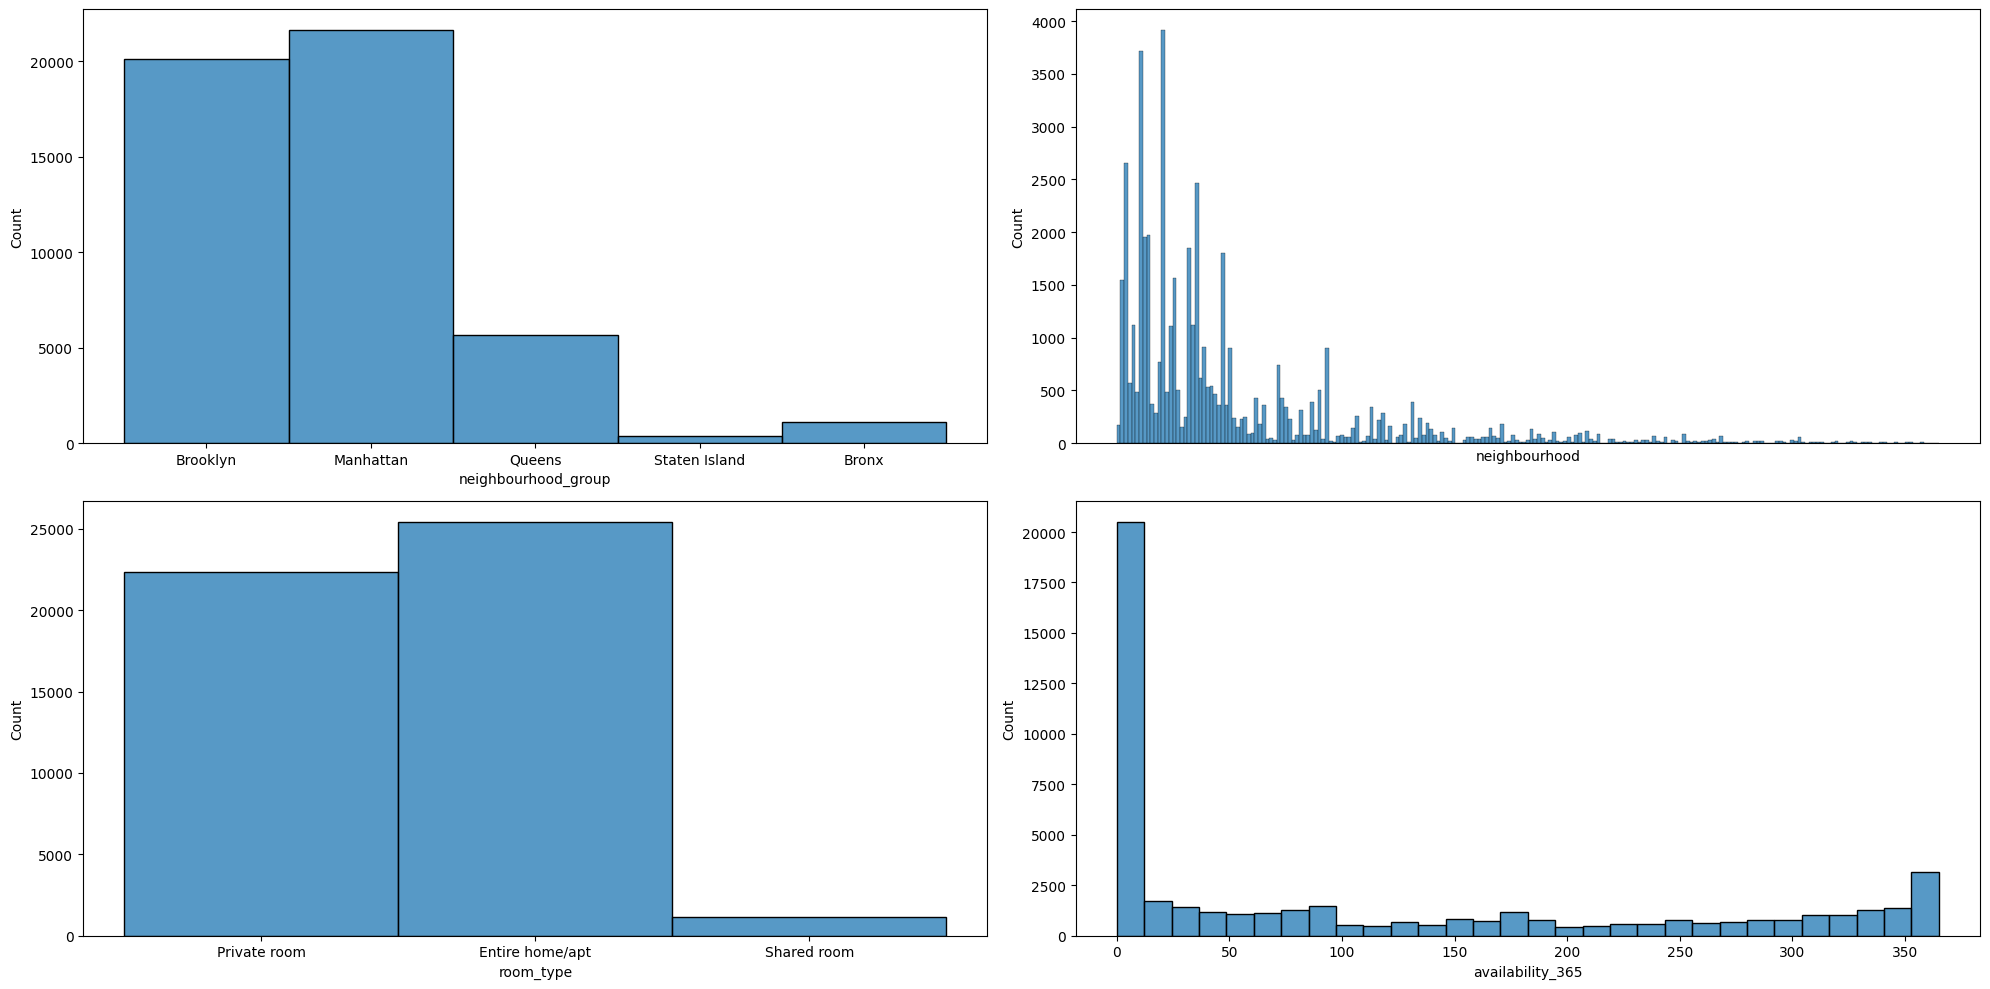

In [16]:
#Vamos a plotear los datos de las columnas categoricas y que hemos dejado, con subplots y seaborn

fig, axis = plt.subplots(2,2, figsize=(20,10))

sns.histplot(ax= axis[0,0], data=datos, x='neighbourhood_group')
sns.histplot(ax= axis[0,1], data=datos, x= 'neighbourhood').set_xticks([]) #set_xticks deja solo un valor en caso de que sean muchos y no se visualicen bien
sns.histplot(ax= axis[1,0],data=datos, x='room_type')
sns.histplot(ax= axis[1,1], data=datos, x='availability_365')

plt.tight_layout() #Limpia las salidas de graficos para que no se monten

plt.show()

#Podemos observar en estos histogramas que la mayoria de barrios donde estan los alquileres es en Broklin y Manhathan.
#Las habitaciones compartidas son las menos acesibles en este dataframe de airbnb
#En la culumna de abalible los 365 dias hay muchos valores nulos, esto puede ser un error.

In [17]:
suma_365 = (datos['availability_365'] == 0).sum()

suma_365

17533

In [18]:
datos.describe()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,7.143982,112.781327
std,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,32.952519,131.622289
min,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,1.000000,0.000000
25%,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,1.000000,0.000000
50%,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,1.000000,45.000000
75%,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.000000,227.000000
max,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,327.000000,365.000000


In [19]:
datos

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...
48890,8232441,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,2,9
48891,6570630,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,2,36
48892,23492952,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,1,27
48893,30985759,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,6,2


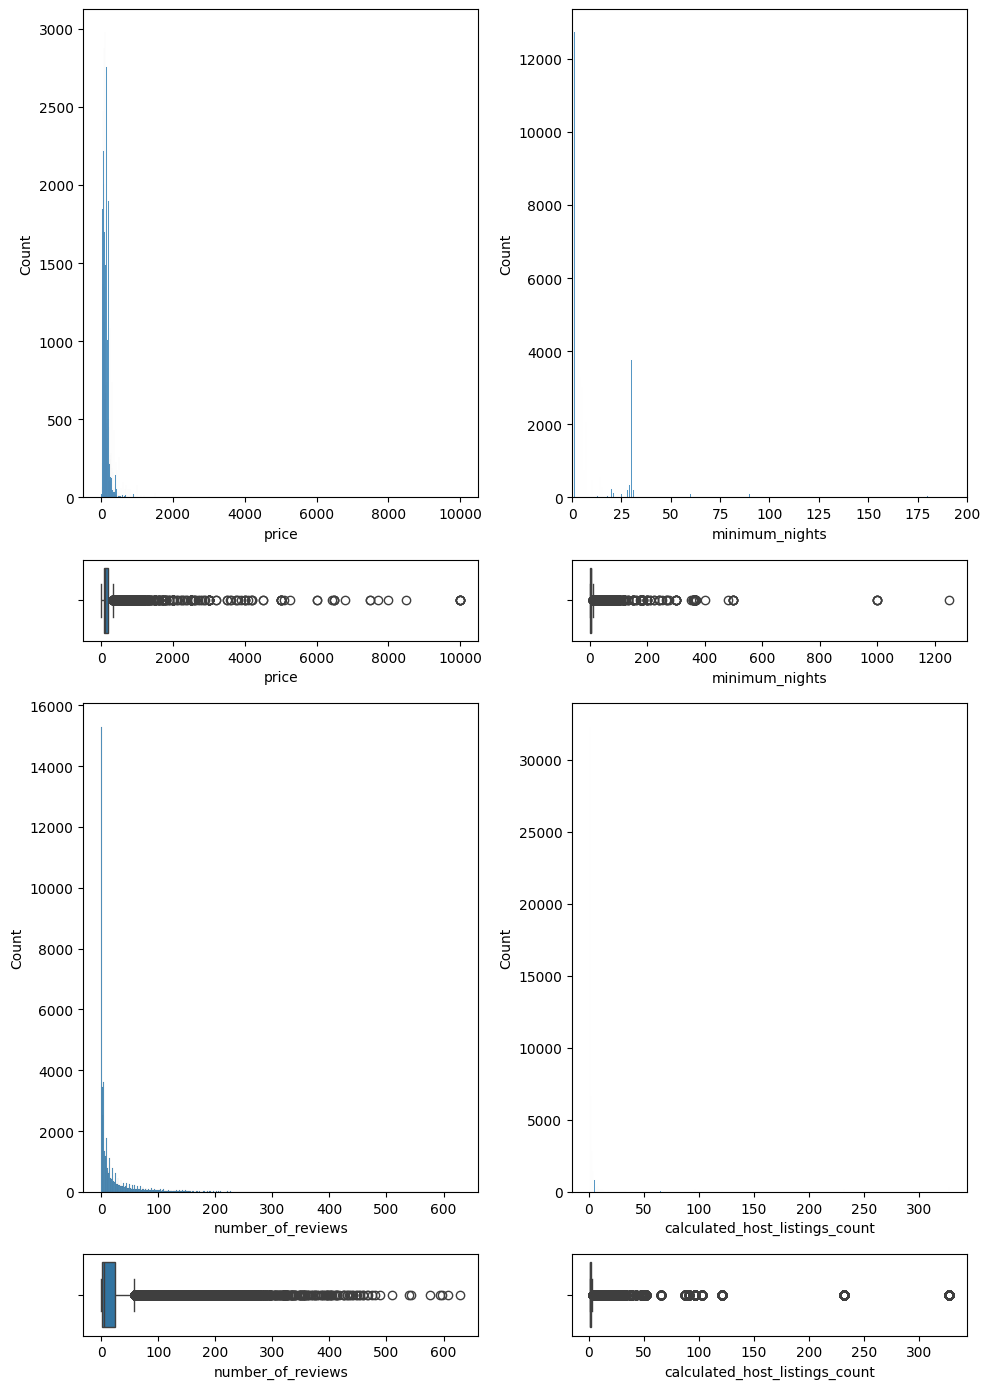

In [20]:
#Ahora vamos a plotear los valores numericos del dataframe y analizarlos:

fig, axis = plt.subplots(4, 2, figsize = (10, 14), gridspec_kw = {"height_ratios": [6, 1, 6, 1]})#Esta ultima linea administra el tamaño de las columnas y las filas en determinados tamaños dados en height ratios

sns.histplot(ax = axis[0, 0], data = datos, x = "price")
sns.boxplot(ax = axis[1, 0], data = datos, x = "price")

sns.histplot(ax = axis[0, 1], data = datos, x = "minimum_nights").set_xlim(0, 200)#Ajustamos los maximos del eje X para que se puedan visualizar mejor los datos en la grafica
sns.boxplot(ax = axis[1, 1], data = datos, x = "minimum_nights")

sns.histplot(ax = axis[2, 0], data = datos, x = "number_of_reviews")
sns.boxplot(ax = axis[3, 0], data = datos, x = "number_of_reviews")

sns.histplot(ax = axis[2,1], data = datos, x = "calculated_host_listings_count")
sns.boxplot(ax = axis[3, 1], data = datos, x = "calculated_host_listings_count")

# Ajusta las tablas
plt.tight_layout()

plt.show()

In [21]:
datos

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...
48890,8232441,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,2,9
48891,6570630,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,2,36
48892,23492952,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,1,27
48893,30985759,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,6,2


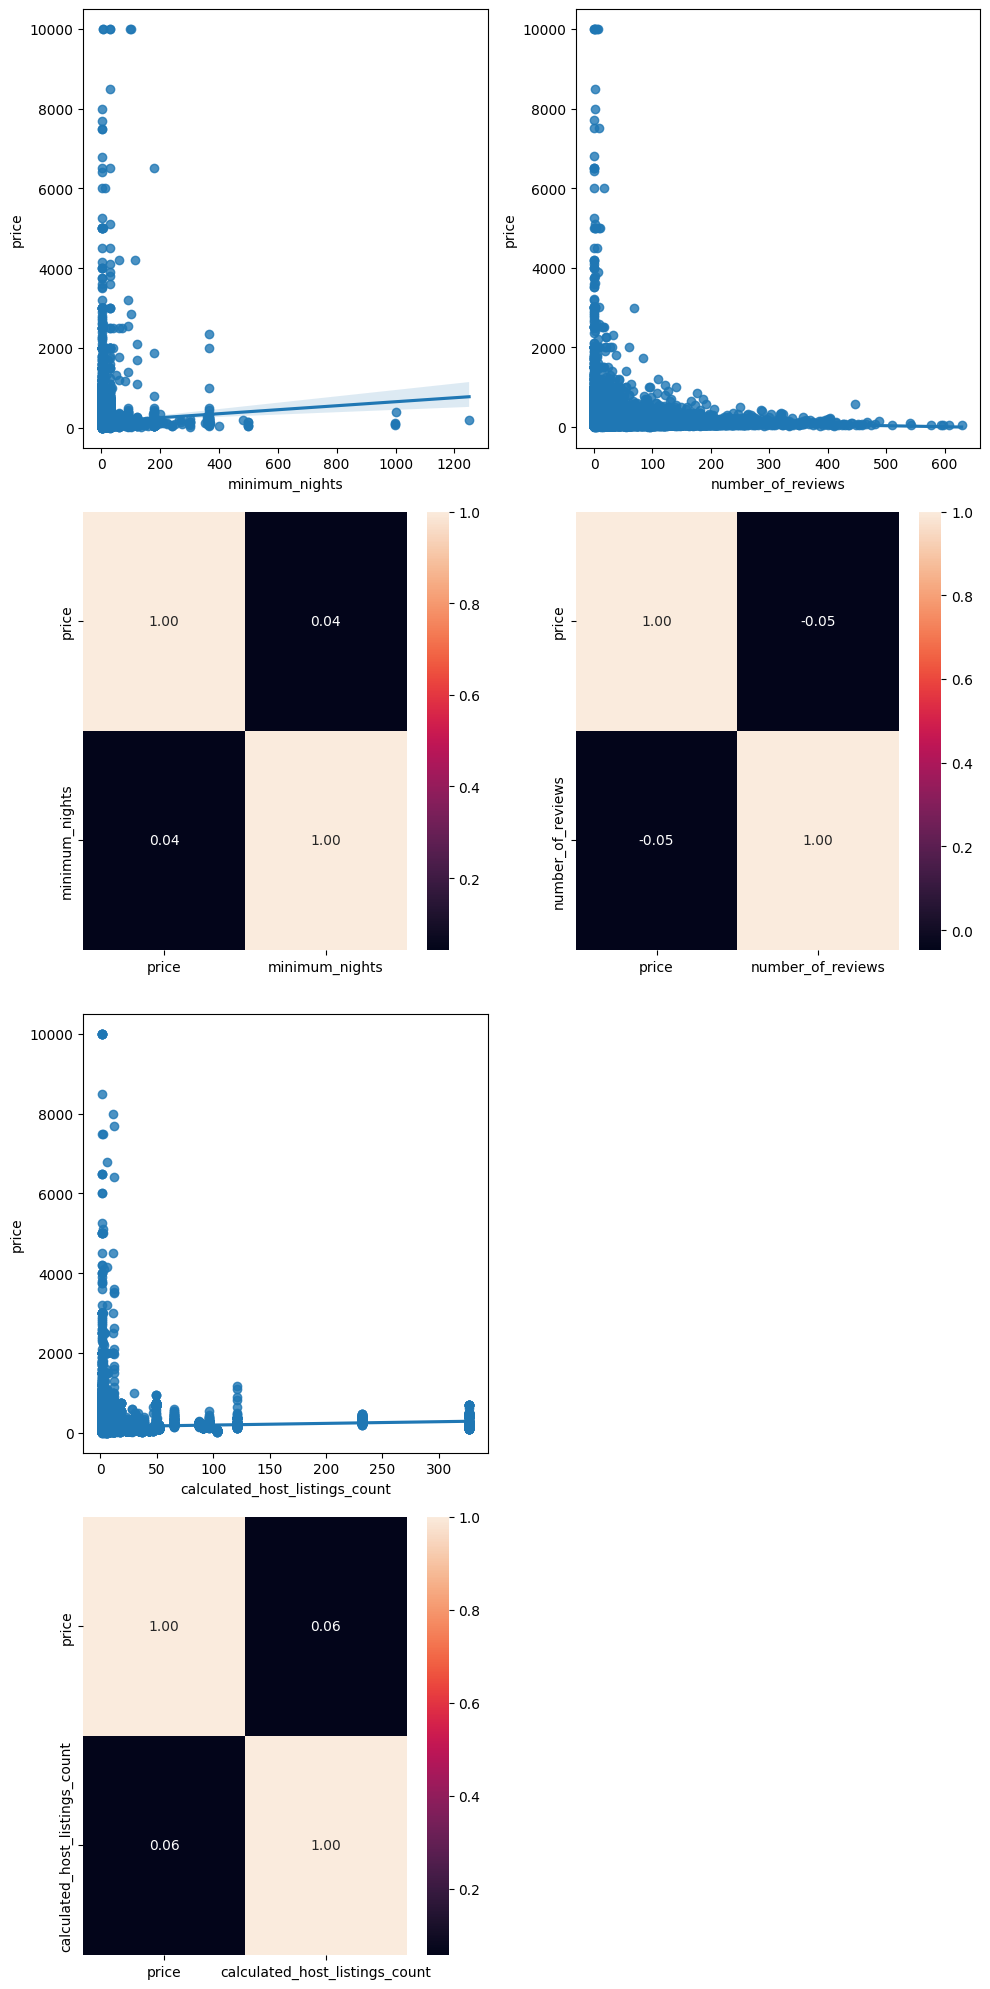

In [22]:
#Analisis, comparacion y relacion de variables numericas respecto a precio.

fig, axis = plt.subplots(4,2, figsize=(10,20))

sns.regplot(ax=axis[0,0], data=datos, x='minimum_nights', y='price')
sns.heatmap(datos[["price", "minimum_nights"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0])

sns.regplot(ax=axis[0,1], data=datos, x='number_of_reviews', y='price')
sns.heatmap(datos[['price','number_of_reviews']].corr(),annot=True,fmt='.2f',ax=axis[1,1])

sns.regplot(ax=axis[2,0], data=datos, x='calculated_host_listings_count', y='price')
sns.heatmap(datos[['price','calculated_host_listings_count']].corr(), annot=True, fmt='.2f',ax=axis[3,0])

fig.delaxes(axis[2,1]) #Estas lineas eliminan las tablas que no queremos que se vean en los subplots
fig.delaxes(axis[3,1])

plt.tight_layout()

plt.show()

#No hay relación entre el precio y las noches mínimas.
#No hay relación entre el número de reseñas y el precio.



'Manhattan es el lugar con más espacios disponibles para alquilar y es el que tiene más casas/departamentos completos disponibles para alquilar.\n\nBrooklyn es el segundo grupo más grande en alquiler, pero tiene más habitaciones privadas, lo que probablemente indica que más personas comparten su hogar o intentan maximizar su espacio.\n\nQueens y Bronx ocupan el tercer y cuarto lugar y comparten el mismo principio que Brooklyn.\n\nStaten tiene una presencia casi inexistente y no es muy propenso a AirBnb.\n\nSin embargo, aparte de esto, no hay una gran relación entre el tipo de habitación y el barrio.'

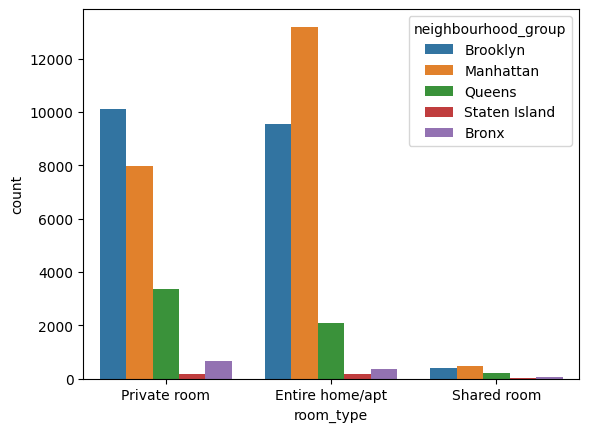

In [23]:
#Analizamos las categoricas

sns.countplot(data = datos, x = "room_type", hue = "neighbourhood_group")

'''Manhattan es el lugar con más espacios disponibles para alquilar y es el que tiene más casas/departamentos completos disponibles para alquilar.

Brooklyn es el segundo grupo más grande en alquiler, pero tiene más habitaciones privadas, lo que probablemente indica que más personas comparten su hogar o intentan maximizar su espacio.

Queens y Bronx ocupan el tercer y cuarto lugar y comparten el mismo principio que Brooklyn.

Staten tiene una presencia casi inexistente y no es muy propenso a AirBnb.

Sin embargo, aparte de esto, no hay una gran relación entre el tipo de habitación y el barrio.'''


In [24]:
datos

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...
48890,8232441,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,2,9
48891,6570630,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,2,36
48892,23492952,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,1,27
48893,30985759,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,6,2


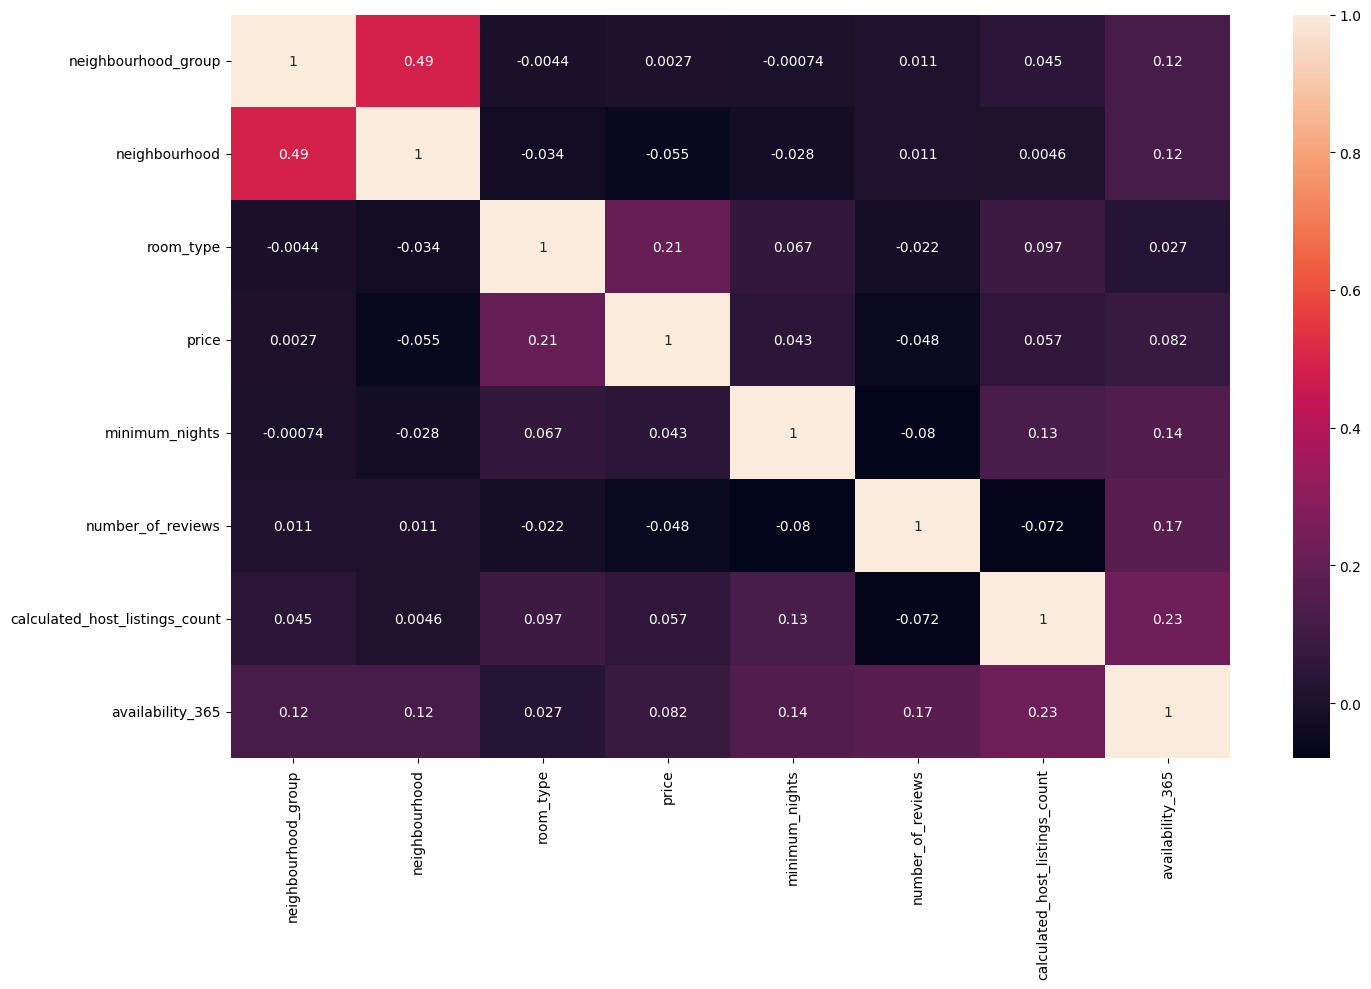

In [25]:
datos['neighbourhood_group'] = pd.factorize(datos['neighbourhood_group'])[0] #factorizamos los valores categoricos convirtiendolos a numericos, donde elegiremos el valor 0, para no escoger las categoricas de los 2 arrays que se nos crean
datos['neighbourhood'] = pd.factorize(datos['neighbourhood'])[0]
datos['room_type'] = pd.factorize(datos['room_type'])[0]

plt.figure(figsize=(15,10))

sns.heatmap(datos[["neighbourhood_group", "neighbourhood", "room_type", "price", "minimum_nights",	
                        "number_of_reviews", "calculated_host_listings_count", "availability_365"]].corr(), annot=True)

plt.tight_layout()
plt.show()

#Como podemos ver en el mapa de calor, no tenemos relaciones muy significativas

In [26]:
#Vamos a analizar los outliers
datos.describe()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,6.762001e+07,0.786911,29.888782,40.728949,-73.952170,0.567113,152.720687,7.029962,23.274466,7.143982,112.781327
std,7.861097e+07,0.844386,34.676634,0.054530,0.046157,0.541249,240.154170,20.510550,44.550582,32.952519,131.622289
min,2.438000e+03,0.000000,0.000000,40.499790,-74.244420,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,7.822033e+06,0.000000,7.500000,40.690100,-73.983070,0.000000,69.000000,1.000000,1.000000,1.000000,0.000000
50%,3.079382e+07,1.000000,19.000000,40.723070,-73.955680,1.000000,106.000000,3.000000,5.000000,1.000000,45.000000
75%,1.074344e+08,1.000000,37.000000,40.763115,-73.936275,1.000000,175.000000,5.000000,24.000000,2.000000,227.000000
max,2.743213e+08,4.000000,220.000000,40.913060,-73.712990,2.000000,10000.000000,1250.000000,629.000000,327.000000,365.000000


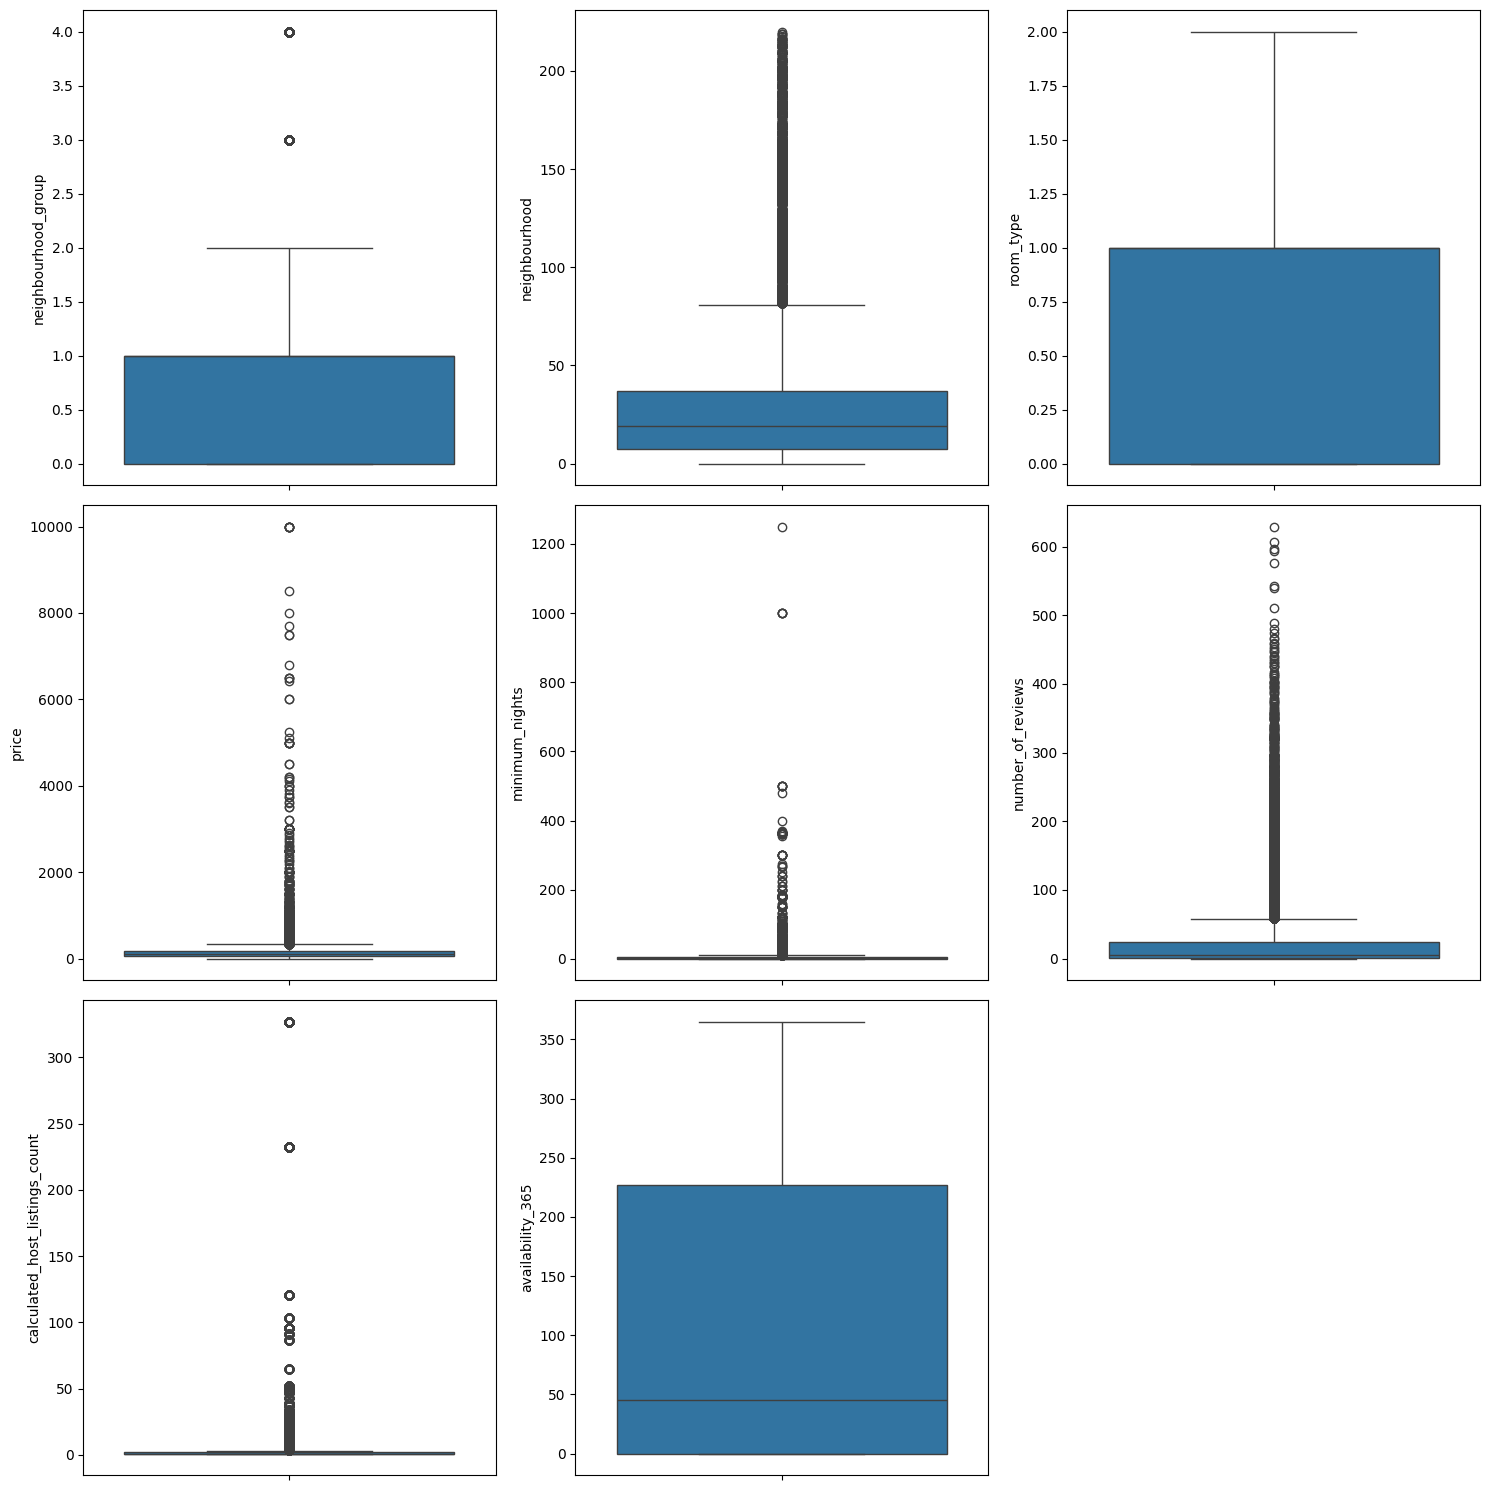

In [27]:
#Vamos a detectar los outliers

fig, axis = plt.subplots(3,3, figsize=(15,15))

sns.boxplot(ax= axis[0,0], data=datos, y='neighbourhood_group')
sns.boxplot(ax= axis[0,1], data=datos, y='neighbourhood')
sns.boxplot(ax= axis[0,2], data=datos, y='room_type')
sns.boxplot(ax= axis[1,0], data=datos, y='price')
sns.boxplot(ax= axis[1,1], data=datos, y='minimum_nights')
sns.boxplot(ax= axis[1,2], data=datos, y='number_of_reviews')
sns.boxplot(ax= axis[2,0], data=datos, y='calculated_host_listings_count')
sns.boxplot(ax= axis[2,1], data=datos, y='availability_365')
plt.delaxes(axis[2,2])

plt.tight_layout()
plt.show()

In [28]:
#Ahora que los hemos visto graficamente los vamos a detectar individualmente
#Outliers de precio:
precio_out = datos['price'].describe()
precio_out

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [29]:
#Calculo de IQR:
#Intercualtilico:
precio_iqr = precio_out['75%'] - precio_out['25%'] #Calcula la dispersion del iqr entre el 75% y el 25%, qr1 y qr3
#El factor1.5 se utiliza para definir un umbral estándar en la detección de valores atípicos usando el Rango Intercuartílico (IQR).
limite_superior = precio_out['75%'] + 1.5 * precio_iqr #calcula los limites que sobresales del limite qr3, por eso sumamos, para sacar los valores por encima
limite_inferior = precio_out['25%'] - 1.5 * precio_iqr

print(f'Los limites superiores e inferiores que sobresales de los valores intercualtilicos son: Superior: {round(limite_superior)} e inferior: {round(limite_inferior)} en el rango de {precio_iqr}')

datos_filtrados = datos[datos['price'].between(limite_inferior, limite_superior)] #Aqui solo seleccionamos los valores que estan entre q1 y q3 y los almacenamos en una tabla limpia de outliers para precio

print(datos.shape)
print(datos_filtrados.shape)

Los limites superiores e inferiores que sobresales de los valores intercualtilicos son: Superior: 334 e inferior: -90 en el rango de 106.0
(48895, 11)
(45923, 11)


In [30]:
#Hacemos lo mismo para las noches minimas:

noches_out = datos['minimum_nights'].describe()

noches_iqr = noches_out['75%'] - noches_out['25%']

noches_limite_superior = noches_out['75%'] + 1.5 * noches_iqr
noches_limite_inferior = noches_out['25%'] - 1.5 * noches_iqr

print(f'Los valores intercualtiles son: Superior {round(noches_limite_superior)} e inferior: {round(noches_limite_inferior)} con el rango de {round(noches_iqr)}')

#Filtramos:

datos_filtrados = datos_filtrados[datos_filtrados['minimum_nights'].between(noches_limite_inferior, noches_limite_superior)]

print(datos.shape)
print(datos_filtrados.shape)

#Vamos a ver tambien los valores que hay en el rango intercualtil y contarlos:

conteo = {}

for i in range(5):
    conteo[i] = datos_filtrados[datos_filtrados['minimum_nights'] == i].shape[0]

for index, values in conteo.items():
    print(f'Las noches minimas para el valor {index} es de: {values}')

Los valores intercualtiles son: Superior 11 e inferior: -5 con el rango de 4
(48895, 11)
(39738, 11)
Las noches minimas para el valor 0 es de: 0
Las noches minimas para el valor 1 es de: 12067
Las noches minimas para el valor 2 es de: 11080
Las noches minimas para el valor 3 es de: 7375
Las noches minimas para el valor 4 es de: 3066


In [31]:
#Hacemos lo mismo para el numero de reseñas

reseñas_out = datos['number_of_reviews'].describe()

reseñas_iqr = reseñas_out['75%'] - reseñas_out['25%']

reseñas_sup = reseñas_out['75%'] + 1.5 * reseñas_iqr

reseñas_inf = reseñas_out['25%'] - 1.5 * reseñas_iqr

print(f'Los valores intercualtiles son: Superior: {round(reseñas_sup)} e inferior: {round(reseñas_inf)} con un rango de {round(reseñas_iqr)}')

datos_filtrados = datos_filtrados[datos_filtrados['number_of_reviews'].between(reseñas_inf, reseñas_sup)]

print(datos.shape)
print(datos_filtrados.shape)


Los valores intercualtiles son: Superior: 58 e inferior: -34 con un rango de 23
(48895, 11)
(34075, 11)


In [32]:
datos_filtrados

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2787,0,0,40.64749,-73.97237,0,149,1,9,6,365
1,2845,1,1,40.75362,-73.98377,1,225,1,45,2,355
2,4632,1,2,40.80902,-73.94190,0,150,3,0,1,365
4,7192,1,4,40.79851,-73.94399,1,80,10,9,1,0
10,7702,1,8,40.80316,-73.96545,1,135,5,53,1,6
...,...,...,...,...,...,...,...,...,...,...,...
48890,8232441,0,6,40.67853,-73.94995,0,70,2,0,2,9
48891,6570630,0,21,40.70184,-73.93317,0,40,4,0,2,36
48892,23492952,1,2,40.81475,-73.94867,1,115,10,0,1,27
48893,30985759,1,7,40.75751,-73.99112,2,55,1,0,6,2


In [33]:
#Lo mismo para host_listing

reseñas_out = datos['calculated_host_listings_count'].describe()

lista_iqr = reseñas_out['75%'] - reseñas_out['25%']

lista_sup = reseñas_out['75%'] + 1.5 * lista_iqr

lista_inf = reseñas_out['25%'] - 1.5 * lista_iqr

print(f'Los valores intercualtiles son: Superior: {round(lista_sup)} e inferior: {round(lista_inf)} con un rango de {round(lista_iqr)}')

datos_filtrados = datos_filtrados[datos_filtrados['calculated_host_listings_count'].between(lista_inf, lista_sup)]

print(datos.shape)
print(datos_filtrados.shape)

Los valores intercualtiles son: Superior: 4 e inferior: 0 con un rango de 1
(48895, 11)
(31036, 11)


In [34]:
#Miramos los valores perdidos

datos_filtrados.isnull().sum()

#Como podemos observar no hemos perdido ningun dato a nulo

host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [35]:
datos_filtrados

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
1,2845,1,1,40.75362,-73.98377,1,225,1,45,2,355
2,4632,1,2,40.80902,-73.94190,0,150,3,0,1,365
4,7192,1,4,40.79851,-73.94399,1,80,10,9,1,0
10,7702,1,8,40.80316,-73.96545,1,135,5,53,1,6
18,20950,0,15,40.67592,-73.94694,1,99,3,53,1,21
...,...,...,...,...,...,...,...,...,...,...,...
48889,107716952,2,46,40.69137,-73.80844,0,65,1,0,2,163
48890,8232441,0,6,40.67853,-73.94995,0,70,2,0,2,9
48891,6570630,0,21,40.70184,-73.93317,0,40,4,0,2,36
48892,23492952,1,2,40.81475,-73.94867,1,115,10,0,1,27


In [36]:
#Vamos a escalar todos los valores a numericos de 0 a 1 con la funcion de sklearn MinMaxScaler
datos_numeros = ['neighbourhood_group','neighbourhood','room_type','minimum_nights','number_of_reviews','calculated_host_listings_count','availability_365']

escalador = MinMaxScaler()

escalador_val = escalador.fit_transform(datos_filtrados[datos_numeros])

datos_escalados = pd.DataFrame(escalador_val, index=datos_filtrados.index, columns=datos_numeros)

datos_escalados['price'] = datos_filtrados['price']

datos_escalados.head()


,neighbourhood_group,neighbourhood,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,price
1,0.25,0.004545,0.5,0.0,0.775862,0.5,0.972603,225
2,0.25,0.009091,0.0,0.2,0.000000,0.0,1.000000,150
4,0.25,0.018182,0.5,0.9,0.155172,0.0,0.000000,80
10,0.25,0.036364,0.5,0.4,0.913793,0.0,0.016438,135
18,0.00,0.068182,0.5,0.2,0.913793,0.0,0.057534,99


In [37]:
#Vamos a entrenar el modelo para la prediccion de precio con los datos ya filtrados

# Separar el dataset en variables independientes (X) y variable objetivo/dependiente (y)
X = datos_escalados.drop('price', axis=1)  # Eliminamos la columna 'price' para obtener solo las variables independientes
y = datos_escalados['price']  # Nos quedamos solo con la columna 'price' que es nuestra variable objetivo

# Dividimos los datos en conjuntos de entrenamiento y prueba
# test_size=0.2 significa que el 20% de los datos se utilizarán para pruebas y el 80% para entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializamos el modelo SelectKBest para seleccionar las 4 mejores características basado en la prueba chi2
seleccion_modelo = SelectKBest(chi2, k=4)

# Ajustamos el modelo a los datos de entrenamiento
seleccion_modelo.fit(X_train, y_train)

# Obtenemos una máscara booleana que indica qué características fueron seleccionadas como las "mejores"
seleccionado = seleccion_modelo.get_support()

# Usamos la máscara booleana para transformar los conjuntos X_train y X_test, manteniendo solo las columnas seleccionadas
X_train_seleccionado = pd.DataFrame(seleccion_modelo.transform(X_train), columns=X_train.columns.values[seleccionado])
X_test_seleccionado = pd.DataFrame(seleccion_modelo.transform(X_test), columns=X_test.columns.values[seleccionado])

# Mostramos las primeras filas del conjunto de prueba transformado para ver las características seleccionadas
X_train_seleccionado.head()

,room_type,number_of_reviews,calculated_host_listings_count,availability_365
0,0.0,0.672414,0.5,0.720548
1,0.5,0.000000,0.0,0.032877
2,0.5,0.086207,0.0,0.526027
3,0.0,0.086207,0.0,0.243836
4,0.0,0.103448,0.5,0.002740


In [39]:
X_train_seleccionado["price"] = y_train
X_test_seleccionado["price"] = y_test
X_train_seleccionado.to_csv("../data/processed/clean_train.csv", index = False)
X_test_seleccionado.to_csv("../data/processed/clean_test.csv", index = False)